In [1]:
import change_path
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import tf_memory_limit
import atacseq
import datagen
import evaluation_tools
import pandas as pd
import numpy as np
import viz_sequence

import pickle
import matplotlib.pyplot as plt
from keras.models import load_model

['', '/usr/lib/python35.zip', '/usr/lib/python3.5', '/usr/lib/python3.5/plat-x86_64-linux-gnu', '/usr/lib/python3.5/lib-dynload', '/home/kal/VENV/lib/python3.5/site-packages/', '/home/kal/VENV/lib64/python3.5/site-packages/', '/home/kal/VENV/lib/python3.5/site-packages/IPython/extensions/', '/home/kal/K27act_models/bin/', '/home/kal/TF_models/bin/', '/home/kal/.ipython']


Using TensorFlow backend.
/home/kal/TF_models/bin/sequence.py:275: RuntimeWarning: divide by zero encountered in log
  self.seq = helper.softmax(np.log(dist))
/home/kal/K27act_models/bin/atacseq.py:280: RuntimeWarning: divide by zero encountered in log
  self.seq = helper.softmax(np.log(dist))


In [2]:
# load in some data
peaks_path = '/home/kal/K27act_models/GM_data/k27act_training_regions_cg.bed'
peaks = pd.read_table(peaks_path)
peaks['score'] = np.log( peaks['k27act'] +1)

__PWM Models__

First we'll look at and interprate a pwm model: a linear combination of the strenghts of learned pwms

In [3]:
# load in a model
from keras.losses import mae
custom_dict = {'loss_with_grad':mae, 'grad_penalty':mae}
model = evaluation_tools.ATACmodel('/home/kal/K27act_models/pwm_models/20180806_103757_seq_only/', custom_dict=custom_dict)
print(model.layer_dict.keys())

seq_only=True

dict_keys(['add_rc', 'input_seqs', 'dropout', 'linear_combination', 'conv_in', 'flatten_3', 'stack_fr', 'pool'])


Bias: 0.003961625043302774


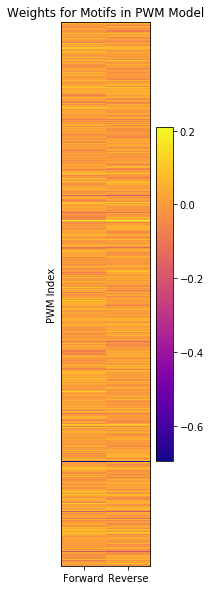

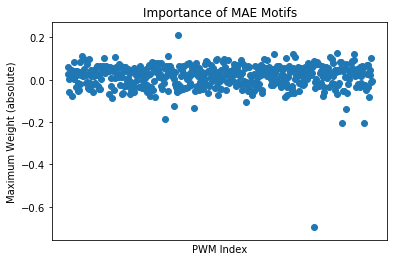

In [4]:
# get the weighting of the pwms
weights = model.layer_dict['linear_combination'].get_weights()[0]
print('Bias: {}'.format(model.layer_dict['linear_combination'].get_weights()[1][0]))
weights = weights.reshape(2, -1)
weights = weights.transpose()

# first half are forward, second half are reverse
plt.figure(figsize=(2,10))
plt.title('Weights for Motifs in PWM Model')
plt.yticks([])
plt.ylabel('PWM Index')
plt.xticks([0,1], ['Forward', 'Reverse'])
plt.imshow(weights, aspect='auto', cmap='plasma')
plt.colorbar()
plt.show()

plt.title('Importance of MAE Motifs')
plt.ylabel('Maximum Weight (absolute)')
plt.xlabel('PWM Index')
plt.xticks([])
maxes = np.amax(weights, axis=1)
mins = np.amin(weights, axis=1)
importance = [m if abs(m) > abs(n) else n for (m, n) in zip(maxes, mins)]
plt.scatter(range(len(importance)), importance)
plt.show()

Importance is 0.21102581918239594


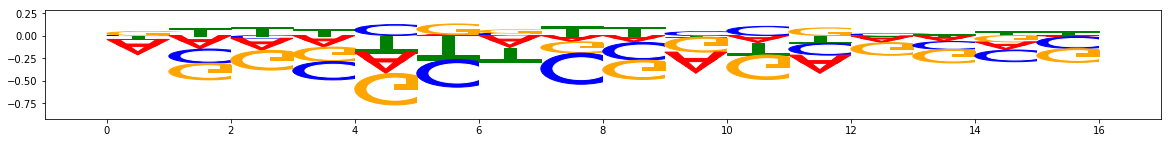

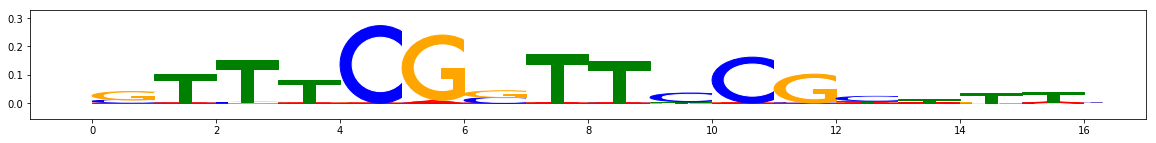

Importance is -0.6961125135421753


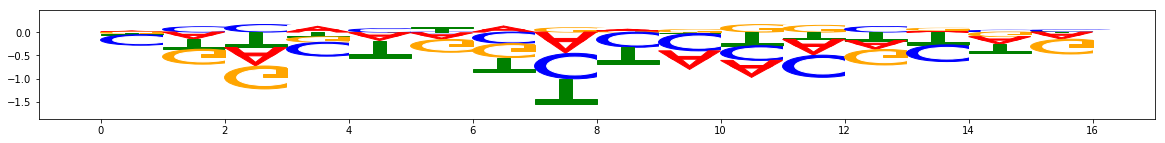

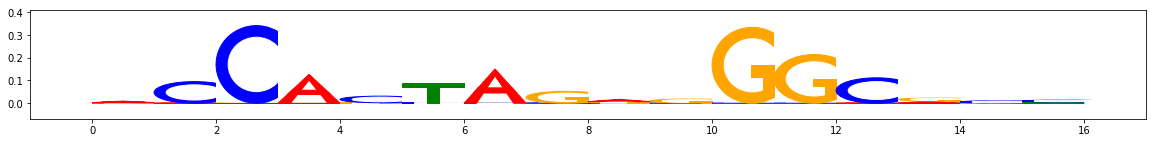

Importance is -0.2022329717874527


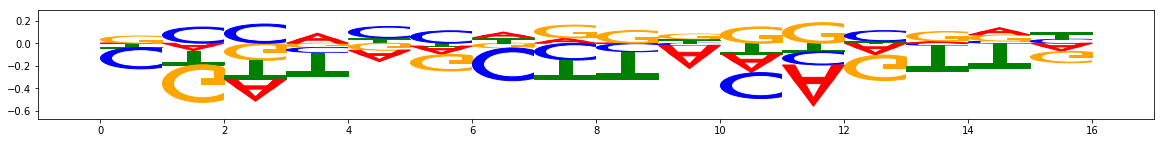

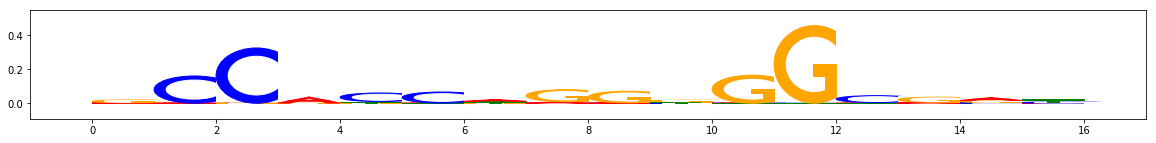

Importance is -0.2042655497789383


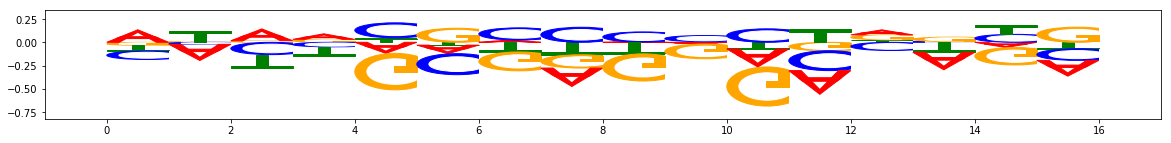

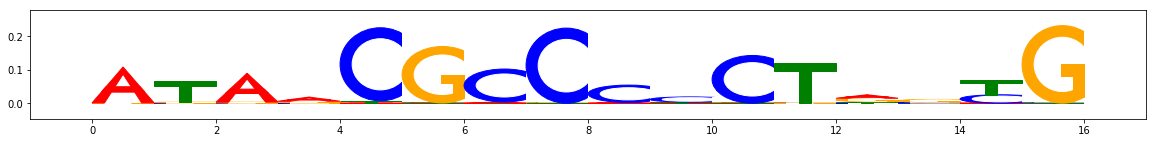

In [5]:
# look at kernels
# make a highlight map
from colour import Color


# plot weights from first layer neurons
temp = 30
weight_array = model.layer_dict['conv_in'].get_weights()[0]
#create highlight dict - with sane maxs and mins
colors = list(Color("blue").range_to(Color("white"), 50))
[colors.append(c) for c in (Color("white").range_to(Color("red"), 51))]
top = np.amax(weight_array[:, 0, :])
bottom = np.amin(weight_array[:, 0, :])
    
       
# got throught the kernels
for idx in range(weight_array.shape[2]):
    if abs(importance[idx]) > .2:
        print('Importance is {}'.format(importance[idx]))
        weight = weight_array[:,:,idx]
        #get hightlights!
        if not seq_only:
            color_weights = [int((x-bottom)/(top-bottom)*100) for x in weight[:,0]]
            highlight=dict()
            for i in range(len(weight)):
                w = color_weights[i]
                highlight[(colors[w].rgb[0],colors[w].rgb[1], colors[w].rgb[2], .3)] = [(i, i+1)]
            #plot things out
            plt.figure(figsize=(20,2))
            plt.title('ATAC weights and sequence for kernel {}'.format(idx))
            plt.plot(weight[:,0])
            plt.show()
            viz_sequence.plot_weights(weight[:, 1:], highlight=highlight)
        else:
            #plot things out
            viz_sequence.plot_weights(weight)
            softmax = np.exp(weight*temp)/np.sum(np.exp(weight*temp))
            viz_sequence.plot_icweights(softmax)

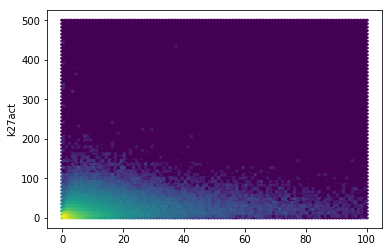

In [6]:
plt.hexbin(peaks['atac'], peaks['k27act'], bins='log', extent=(0, 100, 0 , 500))
plt.ylabel('k27act')
plt.show()

In [7]:
import importlib
importlib.reload(atacseq)

/home/kal/K27act_models/bin/atacseq.py:280: RuntimeWarning: divide by zero encountered in log
  self.seq = helper.softmax(np.log(dist))


<module 'atacseq' from '/home/kal/K27act_models/bin/atacseq.py'>

Score: 1.3296201509399819
Score: 2.926858586754802
Score: 1.0436579885230062
Score: 2.5046340253816335
Score: 5.093681577347656


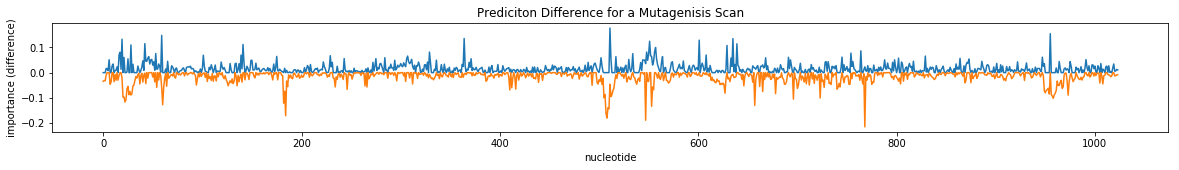

Score: 5.093681577347656
Prediciton
2.6509202


In [8]:
# from a real batch of data
d = datagen.batch_gen(peaks, shuffle=True)
s=[0]
while s[0] < 3:
    b, s = next(d)
    print('Score: ' + str(s[0]))
if seq_only:
    model.get_importance(atacseq.Sequence(b[0,:,1:]), plot=True)
else:
    model.get_importance(atacseq.ATACSeq(b[0]), plot=True)

print('Score: ' + str(s[0]))
print('Prediciton')
if seq_only:
    print(model.get_act([b[:,:,1:], 0])[0][0][0])
else:
    print(model.get_act([b, 0])[0][0][0])

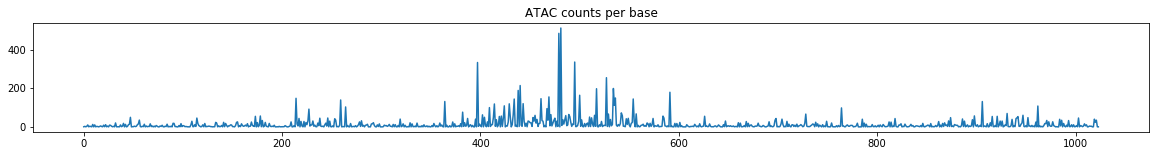

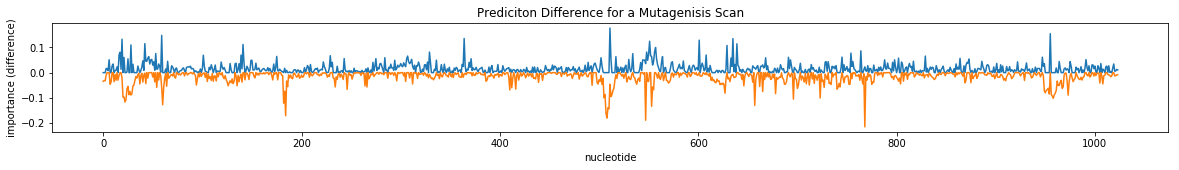

ValueError: Cannot feed value of shape (32, 1024, 5) for Tensor 'input_seqs:0', which has shape '(32, 1024, 4)'

In [9]:
seq = atacseq.ATACSeq(b[0])
seq.graph()
model.get_importance(atacseq.Sequence(seq.seq), plot=True)
model.get_importance(seq, plot=True, start=600, end=700, viz=True, temp=1e-3)
model.get_importance(seq, plot=True, start=800, end=900, viz=True, temp=1e-3)
print('done')

In [ ]:
# get the activation of the network
print(model.layer_dict.keys())
activations = Model(inputs=model.model.input, output=model.layer_dict['pool'].output)
   
acts = activations.predict(b)    
print(acts.shape)
weights = acts[0]
print(weights.shape)
weights = weights.reshape(2, -1)
weights = weights.transpose()

# first half are forward, second half are reverse
plt.figure(figsize=(2,10))
plt.title('Weights for Motifs in PWM Model')
plt.yticks([])
plt.ylabel('PWM Index')
plt.xticks([0,1], ['Forward', 'Reverse'])
plt.imshow(weights, aspect='auto', cmap='plasma')
plt.colorbar()
plt.show()

weight_array = model.layer_dict['conv_in'].get_weights()[0]
# got throught the kernels
for idx in range(weight_array.shape[2]):
    if abs(weights[idx][0]) > 3 or abs(weights[idx][1]) > 3:
        print('Importance is {}'.format(importance[idx]))
        print('Activation is {}'.format(weights[idx]))
        weight = weight_array[:,:,idx]
        #get hightlights!
        color_weights = [int((x-bottom)/(top-bottom)*100) for x in weight[:,0]]
        highlight=dict()
        for i in range(len(weight)):
            w = color_weights[i]
            highlight[(colors[w].rgb[0],colors[w].rgb[1], colors[w].rgb[2], .3)] = [(i, i+1)]
        #plot things out
        plt.figure(figsize=(20,2))
        plt.title('ATAC weights and sequence for kernel {}'.format(idx))
        plt.plot(weight[:,0])
        plt.show()
        viz_sequence.plot_weights(weight[:, 1:], highlight=highlight)
        #softmax = np.exp(weight[:, 1:]*temp)/np.sum(np.exp(weight[:, 1:]*temp))
        #viz_sequence.plot_icweights(softmax, highlight=highlight)

In [ ]:
# block off the motif and see prediction change
print(model.get_act([evaluation_tools.blank_batch(b[0]), 0])[0][0][0])
b1 = b.copy()
b1[0][600:700] = 0
print(model.get_act([evaluation_tools.blank_batch(b1[0]), 0])[0][0][0])

In [ ]:
seq = atacseq.ATACSeq(b[0])
seq.graph()
model.get_importance(seq, plot=True)
model.get_importance(seq, plot=True, start=650, end=750, viz=True, temp=1e-3)
model.get_importance(seq, plot=True, start=550, end=600, viz=True, temp=1e-3)
print('done')

In [ ]:
# shuffle all but the first - does it change predicitons?
b4 = b.copy()
np.random.shuffle(b4)
print(b4[0])
b4[0] = b[0]
print(model.get_act([b4, 0])[0][0][0])

In [ ]:
from keras.models import Model, load_model
print('Initially \n')
print('Input: {}'.format(b4[0][0][0]))
for i in range(len(model.model.layers)):
    model1 = Model(inputs=model.model.input, output=model.model.layers[-i].output)
    print('Layer -{}: {}'.format(i, model1.predict(b4)[0][0]))

In [ ]:
print('\n\nLater \n')
b4 = b.copy()
np.random.shuffle(b4)
b4[0] = b[0]
print(model.get_act([b4, 0])[0][0][0])
print('Input: {}'.format(b4[0][0][0]))
for i in range(len(model.model.layers)):
    model1 = Model(inputs=model.model.input, output=model.model.layers[-i].output)
    print(model.model.layers[-i].name)
    print('Layer -{}: {}'.format(i, model1.predict(b4)[0][0]))

In [ ]:
for b in evaluation_tools.filled_batch(seq.ngram_mutant_gen()):
    print(b.shape)
    print(model.model.predict(evaluation_tools.blank_batch(b[0])))
    print('Predictions')
    print(model.get_act([b, 0]))
    print(model.get_act([evaluation_tools.blank_batch(b[0]), 0])[0][0][0])

In [ ]:
seq, s = datagen.get_sample(peaks.iloc[4])
print(s)
seq = atacseq.ATACSeq(seq)
print(model.get_activation(seq))
print(model.get_activation(seq.ngram_mutant_gen()))
model.get_importance(seq, plot=True)
seq.graph()

In [ ]:
def get_lime(model, seq, viz=False, start=None, end=None, plot=False, temp=.1):
    """Generate the sectioned importance of a given model.
      
    Arguments:
        seq -- the Sequence to run through the keras model.
        viz -- sequence logo of importance?
        start -- plot only past this nucleotide.
        end -- plot only to this nucleotide.
        plot -- generate a gain-loss plot?
    Outputs:
        diffs -- difference at each position to score.
        average_diffs -- base by base importance value. 
        masked_diffs -- importance for bases in origonal sequence.
    """
    score = model.get_activation(seq)
    mutant_preds = model.get_activation(seq.ngram_mutant_gen())
    #get the right shape
    mutant_preds = mutant_preds.reshape((-1, 4))[:len(seq.seq)]
    diffs = mutant_preds - score
    # we want the difference for each nucleotide at a position minus the average difference at that position
    average_diffs = list()
    for base_seq, base_preds in zip(seq.seq, mutant_preds):
        this_base = list()
        for idx in range(4):
            this_base.append(base_preds[idx] - np.average(base_preds))
        average_diffs.append(list(this_base))
    average_diffs = np.asarray(average_diffs)
    # masked by the actual base
    masked_diffs = (seq.seq * average_diffs)
    if plot:
        # plot the gain-loss curve 
        plt.figure(figsize=(20, 2))
        plt.plot(np.amax(diffs, axis=1)[start:end])
        plt.plot(np.amin(diffs, axis=1)[start:end])
        plt.title('Prediciton Difference for a Mutagenisis Scan')
        plt.ylabel('importance (difference)')
        plt.xlabel('nucleotide')
        plt.show()
    if viz:
        temp = temp
        #print('Prediciton Difference')
        #viz_sequence.plot_weights(average_diffs[start:end])
        print('Masked average prediciton difference')
        viz_sequence.plot_weights(masked_diffs[start:end])
        #print('Softmax prediction difference')
        #viz_sequence.plot_weights(helper.softmax(diffs[start:end]))
        print('Information Content of Softmax prediction difference')
        viz_sequence.plot_icweights(helper.softmax(diffs[start:end]/(temp*self.get_activation(seq))))
    return diffs, average_diffs, masked_diffs

In [ ]:
# 

In [ ]:
def gumbel_dream(self, seq, dream_type, temp=10, layer_name='final_output', filter_index=0, meme_library=None, num_iterations=20, step=None, constraint=None, viz=False):
    """ Dream a sequence for the given number of steps employing the gumbel-softmax reparamterization trick.

    Arguments:
        seq -- SeqDist object to iterate over.
        dream_type -- type of dreaming to do. 
            standard: update is average gradient * step
            constrained: dream the rejection of this model against the other model.
   Keywords:
        temp -- for gumbel softmax.
        layer_name -- name of the layer to optimize.
        filter_index -- which of the neurons at this filter to optimize.
        meme_library -- memes to use if applicable (default is CTCF)
        num_iterations -- how many iterations to increment over.
        step -- default is 1/10th the initial maximum gradient
        constraint -- for constrained dreaming, the model to use for rejection.
        viz -- sequence logo of importance?
    Returns:
        dream_seq -- result of the iterations.
    """
    # dreaming won't work off of true zero probabilities - if these exist we must add a pseudocount
    if np.count_nonzero(seq.seq) != np.size(seq.seq):
        print('Discrete Sequence passed - converting to a distibution via pseudocount')
        dream_seq = sequence.SeqDist(helper.softmax(3*seq.seq + 1))
    else:
        dream_seq = sequence.SeqDist(seq.seq)

    # get a gradient grabbing op
    #input underlying distribution as (batch_size, 256, 4) duplications of the sequence
    dist = tf.placeholder(shape=((256,4)), name='distribution', dtype=tf.float32)
    logits_dist = tf.reshape(dist, [-1,4])
    # sample and reshape back (shape=(batch_size, 256, 4))
    # set hard=True for ST Gumbel-Softmax
    sampled_seq = tf.reshape(train_TFmodel.gumbel_softmax(logits_dist, temp, hard=True),[-1, 256, 4])
    sampled_seq = self.model.input
    if layer_name == 'final_output':
        loss = self.model.output
    else:
        max_by_direction = Lambda(lambda x: K.maximum(K.max(x[:x.shape[0]//2, :, :], axis=1), K.max(x[x.shape[0]//2:, ::-1, :], axis=1)), name='stackmax', output_shape=lambda s: (s[0] // 2, 1))
        layer_output = max_by_direction(self.layer_dict[layer_name].output)
        loss = layer_output[:, filter_index] #each batch and nuceotide at this neuron.
    # compute the gradient of the input seq wrt this loss and average to get the update (sampeling already weights for probability)
    if dream_type == 'constrained':
        sampled_seq = constraint.model.input
        pwm_loss = constraint.output
        grads = K.gradients(loss, sampled_seq)[0]
        pwms = K.gradients(pwm_loss, sampled_seq)[0] 
        update = K.mean(helper.rejection(grads, pwms), axis=0)
    else:
        update = K.mean(K.gradients(loss, sampled_seq)[0], axis=0)
    #get a function
    update_op = K.function([sampled_seq, K.learning_phase()], [update])

    #find a step size
    if step == None:
        step = 1/(np.amax(update_op([[dream_seq.seq]*32, 0])[0]))
        print('Step ' + str(step))
    # print the initial sequence
    if viz:
        print('Initial Sequence')
        seq.logo()
        print('Model Prediction: ' + str(self.model.predict(train_TFmodel.blank_batch(dream_seq.discrete_seq()))[0][0]))
        self.get_importance(dream_seq, viz=True)
        print('PWM score: ' + str(dream_seq.find_pwm(viz=True)[2]))

    #iterate and dream
    for i in range(num_iterations):
        update = update_op([[dream_seq.seq]*32, 0])[0]
        if dream_type == 'standard':
            dream_seq.seq = helper.softmax(np.log(dream_seq.seq) + update*step)
        elif dream_type == 'adverse':
            dream_seq.seq = helper.softmax(np.log(dream_seq.seq) + update*step -1) 
        elif dream_type == 'blocked':
            meme, position, _ = dream_seq.find_pwm(meme_library=meme_library)
            update[position:position+meme.seq.shape[0]] = 0
            dream_seq.seq = helper.softmax(np.log(dream_seq.seq) + update*step)
        if i%(num_iterations//4) == 0 and viz:
            print('Sequence after ' + str(i) + ' iterations')
            viz_sequence.plot_icweights(dream_seq.seq)
 
    #print the final sequence
    if viz:
        print('Final sequence')
        dream_seq.logo()
        print('Model Prediction: ' + str(self.model.predict(train_TFmodel.blank_batch(dream_seq.discrete_seq()))[0][0]))
        self.get_importance(dream_seq, viz=True)
        print('PWM score: ' + str(dream_seq.find_pwm(viz=True)[2]))
    return dream_seq     


def build_iterate(self, layer_name='final_output', filter_index=0):
    """ Build a interation operation for use with dreaming method.
 
    Keywords:
      layer_name -- layer dictionary enry to get the output from.
      filter_index -- inex of the filter to pull from the layer. 
    Output:
        iterate_op -- iteration operation returning gradients.
    """
    # set a placeholder input
    encoded_seq = self.model.input
    # build a function that sumes the activation of the nth filter of the layer considered
    if layer_name == 'final_output':
        activations = self.model.output
        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(K.mean(activations), encoded_seq)[0]
    else:
        layer_output = self.layer_dict[layer_name].output
        activations = layer_output[:, :, filter_index] #each batch and nuceotide at this neuron.
        # forward and reverse sequences
        combined_activation = K.mean(np.maximum(activations[:32], activations[32:]))
        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(combined_activation, encoded_seq)[0]
        # normalization trick: we normalize the gradient - not sure if I should use this
        # grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    # this function returns the loss and grads given the input picture
    iterate_op = K.function([encoded_seq, K.learning_phase()], [grads])
    return iterate_op 

In [ ]:
x = np.asarray(range(60)).reshape((2,10,3))
print(x)
np.concatenate([x[:x.shape[0]//2, :, :], x[x.shape[0]//2:, ::-1, :]], axis=2)

In [ ]:
def add_RC(x):
        RC = np.concatenate([x[:, ::-1, :1], x[:, ::-1, 1:][:, :, ::-1]], axis=2)
        return np.concatenate([x, RC], axis=0)

In [ ]:
x[:, ::-1, 1:][:, :, ::-1]

In [ ]:
add_RC(x)

In [ ]:
x = np.asarray(range(10))
y = np.append(x, x)
y.reshape(2, -1)